# Positional Encoding Schemas

This notebook will be housed as a methods and tutorial like notebook for how to apply varying Positional Encoding (PE) methods. This will be important for the testing purposes of the MStA Transformer that I currently have.
These methods will be applied to the model to see which will apply cyclic information successfully.
The four different approaches that I am going to currently test are:

- Absolute PE
- Random (on the fly) Relative PE
- Symmetric Relative Distance PE
- Offset (Cyclic) Relative PE

Formulas and desired outputs will be explicilty stated for easy implementation and understanding

## Inital Variables

First, we have to make a set of shareable inputs and functions that can be used across the methods. Also, of course load in the relavent modules that are important for us.

In [159]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import math

In [386]:
# Dimensions
B = 100 # Batch
L = 8   # Length (Sequence)
dx = 128 # Sequence Embedding
D = 128 # Embedding Dimension
# Within this example dx and D are the same shape, but they are separated for the case that they may not be.

# Instantiate the same x input shape and array for every PE
x = torch.rand(size=(B, L, dx))

# Also, we want the same linear funcitons
q_linear = nn.Linear(dx, D, bias=False)
k_linear = nn.Linear(dx, D, bias=False)
v_linear = nn.Linear(dx, D, bias=False)

# Or we can instantiate some weight matrices that will be used to multiply x by
q_W = torch.rand(size=(dx, D), requires_grad=True)
k_W = torch.rand(size=(dx, D), requires_grad=True)
v_W = torch.rand(size=(dx, D), requires_grad=True)

### Within this example $d_x$ and $D$ are the same shape, but they are separated for the case that they may not be.

---
# Absolute PE


Attention Is All You Need (Vaswani et al. 2017) https://arxiv.org/pdf/1706.03762.pdf

The idea behind Absolute PE, is that sinusoidal information will be added or concatonated to the $x$ information, before going through the transformer. These $\sin$ and $\cos$ information are alternatingly added to $2i$ and $2i+1$ entries within the $d_x$ dimensions within our example.

This can be written as:

$ PE(pos, 2i) = \sin(\frac{pos}{10000^{\frac{2i}{d_x}}}) $

$ PE(pos, 2i+1) = \cos(\frac{pos}{10000^{\frac{2i}{d_x}}}) $

Since, this is added to x before going through the model it can be implemented trivially.

In [175]:
# init the pe positional tensor
pe = torch.zeros(L, dx)

# Make a row vector of each position
position = torch.arange(0, L, dtype=torch.float).unsqueeze(1)

# Calculate the division term using exponetnial and log forms
div_term = torch.exp(torch.arange(0, dx, 2).float() * (-np.log(10000) / dx))

# Now add these to pe
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)

# change the shape and permute pe (L, dx) -> (1, L, dx) -> (L, 1, dx)
pe = pe.unsqueeze(0).transpose(0,1)

# x needs to be permuted, so that the pe matrix can be broadcasted across each batch
# After adding on pe, we can permute the resulting x to be back to the original dimensions
# (L, B, D) -> (B, L, D)
x_pe = (x.permute(1, 0, 2) + pe).permute(1, 0, 2)

---

# Random Init Relative PE

Self-Attention with Relative Position Representations - Shaw et al. 2019 (https://arxiv.org/pdf/1803.02155.pdf)

First we have to generate our values $Q, K, V \in \mathbb{R}^{B \times L \times D}$ by passing them through a linear layer (without a bias term) or multiply them by a weight matrix $W^{Q}, W^{K}, W^{V} \in \mathbb{R}^{d_x \times D}$ where in this case $d_x = D$.

Our input $x \in \mathbb{R}^{B \times L \times d_x}$


Also, since this is the random version we must initalize our $a^K \&$ $a^V \in \mathbb{R}^{L \times L \times D}$

In [271]:
# First we have to get our Q, K, and V of size (B, L, D) after linear function
# Q, K, V = q_linear(x), k_linear(x), v_linear(x) # Linear no bias 
# or multiply weights
Q, K, V = torch.matmul(x,q_W), torch.matmul(x,k_W), torch.matmul(x,v_W)

# Now instantitate the ak and av learnable edge information
ak = nn.Parameter(torch.rand(size=(L, L, D), requires_grad=True))
av = nn.Parameter(torch.rand(size=(L, L, D), requires_grad=True))

Now that we have our values, we can calculate everything that we need. First we must compute our edge interactions $e$. This can be done:

$ e_{ij} = \frac{x_i W^{Q}(x_j W^{K} + a_{ij}^{K})^{\top}}{\sqrt(d_z)}$

$e \in \mathbb{R}^{B \times L \times L}$

In [315]:
# First part of numerator is standard dot product
e_num1 = torch.matmul(Q, K.transpose(-1,-2))

# Second part of numerator needs to be permuted and then multiplied
ak_t = ak.transpose(1,2) # (L, L, D) -> (L, D, L)
Q_p = Q.permute(1, 0, 2) # (B, L, D) -> (L, B, D)
num2 = torch.matmul(Q_p, ak_t) # (L, B, D) * (L, D, L) - >  (L, B, L)
num2_p = num2.permute(1, 0, 2) # (L, B, L) -> (B, L, L)

# Now we can add the numerators
num = e_num1 + num2_p

# and normalize 
e = num / math.sqrt(D)

In [316]:
mask = torch.tril(torch.ones(L, L)).unsqueeze(0)
e = e.masked_fill(mask == 0, float("-inf"))

With the edge information we can generate an edge attention/weight matix $\alpha$. 
Where:

$\alpha_{ij} = \frac{\exp{e_{ij}}}{\sum_{k=1}^{n} \exp{e_{ik}}}$

$\alpha \in \mathbb{R}^{B \times L \times L}$

In [317]:
# Now we can compute alpha (softmax) over ith values
alpha = nn.functional.softmax(e, dim=-1)  #torch.exp(e) / torch.einsum('bij,bik->bij', torch.exp(e), torch.exp(e)) This didn't seem to work. Might need to check

Next we have to compute $z_i$. Where we sum over every interaction for $i$, scaled by $\alpha$ and edge contributions added with $a^{V}$.

$ z_i = \sum_{j=1}^{n} \alpha_{ij}(x_j W^V + a_{ij}^V)$

In [318]:
# Now we can compute z, but following what we did above
z_1 = torch.matmul(
    alpha,
    V
)
z_2 = torch.matmul(
    alpha.permute(1, 0, 2), # (B, L, L) -> (L, B, L)
    av # (L, L, D)
).permute(1, 0, 2) # (L, B, D) -> (B, L, D)

# Add the two z components together
z = nn.functional.softmax(z_1 + z_2, dim=-1)

In [319]:
z[0, :, :]

tensor([[1.0781e-02, 9.2133e-04, 7.4437e-05,  ..., 1.0268e-03, 8.2101e-05,
         5.3857e-04],
        [1.5318e-02, 1.2921e-03, 5.8624e-05,  ..., 1.0828e-03, 1.9308e-04,
         3.4863e-04],
        [1.5936e-02, 8.9296e-04, 3.8795e-05,  ..., 2.1698e-03, 1.6133e-04,
         3.3197e-04],
        ...,
        [1.7682e-02, 7.4715e-04, 9.8702e-05,  ..., 1.5342e-03, 1.7090e-04,
         5.7108e-04],
        [9.2319e-03, 9.7564e-04, 7.6433e-05,  ..., 1.1160e-03, 1.4333e-04,
         3.1088e-04],
        [1.5253e-02, 8.4498e-04, 6.2887e-05,  ..., 1.9056e-03, 1.3085e-04,
         5.2658e-04]], grad_fn=<SliceBackward0>)

We end our attention run through with $z \in \mathbb{R}^{B \times L \times D}$

---

# Symmetric Relative PE

The implementation of this method will be done the same as the Random Init Relative PE method.
However, the $a^{K}$ & $a^{V}$ values will be filled by embeddings computed from relative distances.

This can be done, by computing a symmetric distance matrix $R \in \mathbb{R}^{L \times L}$

In [244]:
# First we compute a symmetric matrix

# Generate the ith column index
i = torch.arange(L)

# Now we compute the symmetric distance
dist = i[:, None] - i[None, :]

# now fix the sign
R = torch.abs(dist)

Text(0.5, 1.0, 'Symmetric Relative PE')

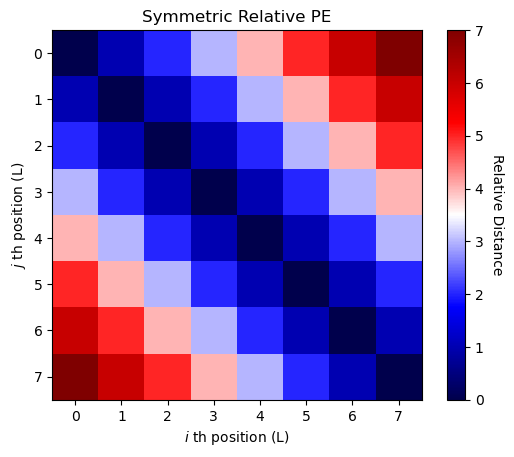

In [245]:
# We can check and visualize our data
fig, ax = plt.subplots()

# Plot values
heatmap = ax.imshow(R, cmap="seismic")

# Plot cbar 
cbar = plt.colorbar(heatmap)
cbar.set_label("Relative Distance", rotation=270, labelpad=15)

plt.xlabel("$i$ th position (L)")
plt.ylabel("$j$ th position (L)")
plt.title("Symmetric Relative PE")

We can see from the graph above, we have the desired $R$ matrix that is symmetric

Next, we have to embed this distance information into $D$ space, so that we can generate our $a^K$ & $a^V$ tensors

In [202]:
# instantiate the embedding functions for both relation distances
aV_embed = nn.Embedding(L, D)
aK_embed = nn.Embedding(L, D)

# Construct our embed symmetric matrix
aK = aV_embed(R)
aV = aK_embed(R)

Our resulting $a^K$ & $a^K \in \mathbb{R}^{L \times L \times D}$, which is the same before. This means we can now perform the same operation as we did before!
Follow Random Init Relative PE directions above!

---
# Offset (Cyclic) Relative PE

Again, the implementation of this method will be done the same as the Random Init Relative PE method.

However, the $a^{K}$ & $a^{V}$ values will be filled by embeddings computed from relative offset distances.

This can be done, by computing a symmetric distance matrix $R \in \mathbb{R}^{L \times L}$ and then computing the offset distances, as shown below.

In [246]:
# Generate the ith column index
i = torch.arange(L)

# Take make a 2d tensor of size (L, 2) Where we can (i, i+L), so we have to flip the stack
ij = torch.stack((i, i+L), dim=-1)

# We make the same symmetric matrix from before
offset = i[:, None] - i[None, :]

# Now we use a dimension trick to compute the absolute distances between ij by adding ij.unsqueeze(1, 2) and ij.unsqueeze(0,1)
# This allows us to compute the cyclic position in the resulting tensors 2nd dimension. 
c_offset = torch.abs(ij[:, None,:, None] - ij[None, :, None, :])

# Then we an compute the distances by taking the min from that 2nd and 3rd resulting dimension
R = torch.tensor(c_offset.numpy().min((2,3)))

# Now we need to flip the sign of values that are less than the offset distance 
a = R < torch.abs(offset)
R[a] = -R[a]

# Fully we reflip the signs 
R = R * torch.sign(offset)

Text(0.5, 1.0, 'Offset/Cyclic Relative PE')

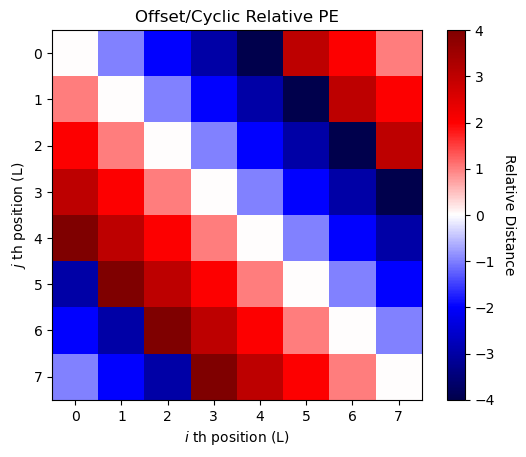

In [370]:
# We can check and visualize our data
fig, ax = plt.subplots()

# Plot values
heatmap = ax.imshow(R, cmap="seismic")

# Plot cbar 
cbar = plt.colorbar(heatmap)
cbar.set_label("Relative Distance", rotation=270, labelpad=15)

plt.xlabel("$i$ th position (L)")
plt.ylabel("$j$ th position (L)")
plt.title("Offset/Cyclic Relative PE")

Seeing that we have a specified offset $R$ matrix now, we can embed this information and create our $a^K$ & $a^V$ relation learned matrices.

In [366]:
# Set embedding function
aK_embed = nn.Embedding(L+1, D)
aV_embed = nn.Embedding(L+1, D)

# Get rid of negative signs, but differentiate between the two
aV_offset = aV_embed(R + L//2)
aK_offset = aK_embed(R + L//2)

Text(0.5, 1.0, 'Offset/Cyclic Relative PE (Range 0 to 8)')

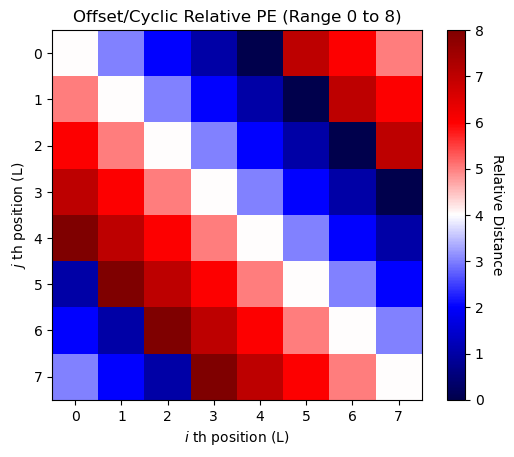

In [369]:
# This graph is just to show that the R + L graph representation is still the same, but now has all tokens between 0 and L
# We can check and visualize our data
fig, ax = plt.subplots()

# Plot values
heatmap = ax.imshow(R + L//2, cmap='seismic')

# Plot cbar 
cbar = plt.colorbar(heatmap)
cbar.set_label("Relative Distance", rotation=270, labelpad=15)

plt.xlabel("$i$ th position (L)")
plt.ylabel("$j$ th position (L)")
plt.title("Offset/Cyclic Relative PE (Range 0 to 8)")

---
# Model Implementation 

Here we show a possible model implementation for the Relative Attention mechanism within a model

In [570]:
class RelativeAttention(nn.Module):
    def __init__(self,
                 d_model: int,
                 num_heads: int,
                 max_len: int = 1024,
                 dropout: float = 0.1,
                 device: str = "cuda" if torch.cuda.is_available() else "cpu",
                 method: str = "random",
                 ):
        super().__init__()
        """Input for attention and cyclic offset positional encodings

        PARAMETERS
        ----------
        d_model : int
            Dimensionality of the model. In the sense of what is the desired
            out dimension. Also, what is the input dimension size

        num_heads: int
            The number of heads to run

        max_len: int
            Max length sequence. This can be larger then the given dataset, especially
            since the generated encodings are relative

        dropout : float
            The amount of data to dropout

        device: str
            Figures out the cuda or cpu method to use

        method: str
            Specify the method of relative positional encoding desired
        """
        assert d_model % num_heads == 0, "Model Dimensions is not divisible by num-heads"
        self.d_head = d_model // num_heads  # Dimension of each head
        self.max_len = max_len              # Max length of the strings allowed, currently 8
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        
        # No bias only weight matrix
        self.key = nn.Linear(d_model, d_model, bias=False, device=device)
        self.query = nn.Linear(d_model, d_model, bias=False, device=device)
        self.value = nn.Linear(d_model, d_model, bias=False, device=device)
        
        # Specify the particular relative position method you want to use
        if method == "random":
            # Specify the relative matrices aK and aV
            self.aK = nn.Parameter(
                torch.randn(size=(max_len, max_len, self.d_head)).to(device),
                requires_grad=True
            )
            self.aV = nn.Parameter(
                torch.randn(size=(max_len, max_len, self.d_head)).to(device),
                requires_grad=True
            )
        elif method == "symmetric":
            # First make the symmetric distance matrix
            i = torch.arange(max_len)
            dist = i[:, None] - i[None, :]
            R = torch.abs(dist).to(device)
            # Specify learning embedding functions
            self.aK_embed = nn.Embedding(max_len, self.d_head, device=device)
            self.aV_embed = nn.Embedding(max_len, self.d_head, device=device)
            # generate our relative matrices aK and aV
            self.aK = nn.Parameter(
                self.aK_embed(R),
                requires_grad=True,
            )
            self.aV = nn.Parameter(
                self.aV_embed(R),
                requires_grad=True,
            )
        else:
            # First we make an offset distance matrix
            i = torch.arange(max_len)
            ij = torch.stack((i, i+max_len), dim=-1)
            offset = (i[:, None] - i[None, :]).to(device)
            c_offset = torch.abs(
                ij[:, None, :, None] - ij[None, :, None, :]
            )
            R = torch.tensor(c_offset.numpy().min((2,3)), device=device)
            less_than_idx = R < torch.abs(offset)
            R[less_than_idx] = -R[less_than_idx]
            R = R * torch.sign(offset)
            # Specify learning embedding functions
            self.aK_embed = nn.Embedding(max_len+1, self.d_head, device=device)
            self.aV_embed = nn.Embedding(max_len+1, self.d_head, device=device)
            # generate our relative matrices aK and aV
            self.aK = nn.Parameter(
                self.aK_embed(R + max_len//2),
                requires_grad=True,
            )
            self.aV = nn.Parameter(
                self.aV_embed(R + max_len//2),
                requires_grad=True,
            )

        self.register_buffer(
            "mask",
            (torch.tril(torch.ones(max_len, max_len)).unsqueeze(0).unsqueeze(0)).to(device),
            persistent=True
        )

    def forward(self, x, y=None, set_mask=False, return_attention=False):
        # input x shape (Batch, Length, Dim)
        batch_size, seq_len, _ = x.shape

        if seq_len > self.max_len:
            raise ValueError(
                "Sequence length exceeds model capacity"
            )

        # Generate our K, V, Q matrices
        # w.r.t K = XW^(k), Q = XW^(Q), V = XW^(V)
        # Then tranpose K and v, q so that when they multiply QK_t we get L as the output and not D_h
        if y != None:
            k_t  = self.key(y).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1) # (B, H, D_h, L)
            v = self.value(y).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)      # (B, H, L, D_h)
        else:
            k_t = self.key(x).reshape(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1) # (B, H, D_h, L)
            v = self.value(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)      # (B, H, L, D_h)
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, -1).transpose(1,2)           # (B, H, L, D_h)

        # Calculate the edge information
        # Compute Numerator first. Full numerator is Q(K + aK)^{T}
        e_num1 = torch.matmul(q, k_t) # Q * K^T (B, H, L, L)

        # Second Numerator value
        ak_t = self.aK.transpose(1,2).unsqueeze(1) # (L, L, D_h) -> (L, 1, D_h, L)
        q_p = q.permute(2, 0, 1, 3) #(B, H, L, D_h) -> (L, B, H, D_h)
        e_num2 = torch.matmul(q_p, ak_t).permute(1, 2, 0, 3) # (L, B, H, L) -> (B, H, L, L)
        num = e_num1 + e_num2

        # Normalize the numerator by dimension length
        e = num / math.sqrt(self.d_head)

        # Also, compute mask
        if set_mask:
            mask = self.mask[:, :, :seq_len, :seq_len]
            e = e.masked_fill(mask == 0, float("-inf")) # (B, H, L, L)

        # Now we compute the alpha (softmax) attention score
        alpha = nn.functional.softmax(e, dim=-1) #torch.exp(e) / torch.sum( torch.exp(e), dim=1, keepdim=True)

        # Now we can compute the out value z
        z_1 = torch.matmul(
            alpha,
            v,
        )
        z_2 = torch.matmul(
            alpha.permute(2, 0, 1, 3),
            self.aV.unsqueeze(1),
        ).permute(1, 2, 0, 3) #(L, B, H, D) -> (B, H, L, D)
        z = z_1 + z_2

        # Now permute z for final output
        out = z.transpose(1,2).reshape(batch_size, seq_len, -1)

        if return_attention:
            return self.dropout(out), alpha
        else:
            return self.dropout(out)

In [590]:
# Init module
attn = RelativeAttention(num_heads = 4,
                               d_model = 128,
                               max_len = 8,
                               method = "symmetric")
# Run and check
out, attention = attn(x.to("cuda"), set_mask=False, return_attention=True)

# print out
print(out.shape)
print(out[0, :, :])

torch.Size([100, 8, 128])
tensor([[ 0.2692, -0.5380, -0.2958,  ..., -0.0331,  0.2957,  0.3066],
        [ 0.0676, -0.6979, -0.3385,  ...,  0.1554,  0.3388, -0.0621],
        [ 0.3732, -0.7703, -0.0000,  ...,  0.2496,  0.2947, -0.0000],
        ...,
        [ 0.4088, -0.7862, -0.3908,  ...,  0.2787,  0.2090, -0.0000],
        [ 0.1337, -0.7167, -0.4067,  ...,  0.0895,  0.5327, -0.1392],
        [ 0.4399, -0.5035, -0.1923,  ..., -0.0353,  0.0000,  0.3288]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [448]:
# Check to see that parameter is added
named_parameters = dict(attn.named_parameters())
for name, param in named_parameters.items():
    print(f"Parameter name: {name}, Parameter shape: {param.shape}")

Parameter name: aK, Parameter shape: torch.Size([8, 8, 32])
Parameter name: aV, Parameter shape: torch.Size([8, 8, 32])
Parameter name: key.weight, Parameter shape: torch.Size([128, 128])
Parameter name: query.weight, Parameter shape: torch.Size([128, 128])
Parameter name: value.weight, Parameter shape: torch.Size([128, 128])
Parameter name: aK_embed.weight, Parameter shape: torch.Size([9, 32])
Parameter name: aV_embed.weight, Parameter shape: torch.Size([9, 32])


---
# MSA Model Implementation

If we want to implement this type of attention with some MSA Transformer we could configure it like so...

In [561]:
class RelativeMSAAttention(nn.Module):
    def __init__(self,
                 d_model: int,
                 num_heads: int,
                 max_len: int = 1024,
                 dropout: float = 0.1,
                 device: str = "cuda" if torch.cuda.is_available() else "cpu",
                 msa_depth: int = 64,
                 method: str = "random",
                 ):
        super().__init__()
        """Input for attention and cyclic offset positional encodings

        PARAMETERS
        ----------
        d_model : int
            Dimensionality of the model. In the sense of what is the desired
            out dimension. Also, what is the input dimension size

        num_heads: int
            The number of heads to run

        max_len: int
            Max length sequence. This can be larger then the given dataset, especially
            since the generated encodings are relative

        dropout : float
            The amount of data to dropout

        device: str
            Figures out the cuda or cpu method to use

        msa_depth: int
            Amount of sequences within the MSA

        method: str
            Specify the method of relative positional encoding desired
        """
        assert d_model % num_heads == 0, "Model Dimensions is not divisible by num-heads"
        self.d_head = d_model // num_heads  # Dimension of each head
        self.max_len = max_len              # Max length of the strings allowed, currently 8
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout = nn.Dropout(dropout)
        self.msa_depth = msa_depth
        
        # No bias only weight matrix
        self.key = nn.Linear(d_model, d_model, bias=False, device=device)
        self.query = nn.Linear(d_model, d_model, bias=False, device=device)
        self.value = nn.Linear(d_model, d_model, bias=False, device=device)
        
        # Specify the particular relative position method you want to use
        if method == "random":
            # Specify the relative matrices aK and aV
            self.aK = nn.Parameter(
                torch.randn(size=(max_len, max_len, self.d_head)).to(device),
                requires_grad=True
            )
            self.aV = nn.Parameter(
                torch.randn(size=(max_len, max_len, self.d_head)).to(device),
                requires_grad=True
            )
        elif method == "symmetric":
            # First make the symmetric distance matrix
            i = torch.arange(max_len)
            dist = i[:, None] - i[None, :]
            R = torch.abs(dist).to(device)
            # Specify learning embedding functions
            self.aK_embed = nn.Embedding(max_len, self.d_head, device=device)
            self.aV_embed = nn.Embedding(max_len, self.d_head, device=device)
            # generate our relative matrices aK and aV
            self.aK = nn.Parameter(
                self.aK_embed(R),
                requires_grad=True,
            )
            self.aV = nn.Parameter(
                self.aV_embed(R),
                requires_grad=True,
            )
        else:
            # First we make an offset distance matrix
            i = torch.arange(max_len)
            ij = torch.stack((i, i+max_len), dim=-1)
            offset = (i[:, None] - i[None, :]).to(device)
            c_offset = torch.abs(
                ij[:, None, :, None] - ij[None, :, None, :]
            )
            R = torch.tensor(c_offset.numpy().min((2,3)), device=device)
            less_than_idx = R < torch.abs(offset)
            R[less_than_idx] = -R[less_than_idx]
            R = R * torch.sign(offset)
            # Specify learning embedding functions
            self.aK_embed = nn.Embedding(max_len+1, self.d_head, device=device)
            self.aV_embed = nn.Embedding(max_len+1, self.d_head, device=device)
            # generate our relative matrices aK and aV
            self.aK = nn.Parameter(
                self.aK_embed(R + max_len//2),
                requires_grad=True,
            )
            self.aV = nn.Parameter(
                self.aV_embed(R + max_len//2),
                requires_grad=True,
            )

        self.register_buffer(
            "mask",
            (torch.tril(torch.ones(max_len, max_len)).unsqueeze(0).unsqueeze(0).unsqueeze(0)).to(device),
            persistent=True
        )

    def forward(self, x, y=None, set_mask=False, return_attention=False):
        # input x shape (Batch, Length, Dim)
        batch_size, MSA, seq_len, _ = x.shape

        if seq_len > self.max_len:
            raise ValueError(
                "Sequence length exceeds model capacity"
            )

        # Generate our K, V, Q matrices
        # w.r.t K = XW^(k), Q = XW^(Q), V = XW^(V)
        # Then tranpose K and v, q so that when they multiply QK_t we get L as the output and not D_h
        if y != None:
            k_t  = self.key(y).reshape(batch_size, MSA, seq_len, self.num_heads, -1).permute(0, 3, 1, 4, 2)     # (B, H, M, D_h, L)
            v = self.value(y).reshape(batch_size, MSA, seq_len, self.num_heads, -1).permute(0, 3, 1, 2, 4)      # (B, H, M, L, D_h)
        else:
            k_t  = self.key(x).reshape(batch_size, MSA, seq_len, self.num_heads, -1).permute(0, 3, 1, 4, 2)     # (B, H, M, D_h, L)
            v = self.value(x).reshape(batch_size, MSA, seq_len, self.num_heads, -1).permute(0, 3, 1, 2, 4)      # (B, H, M, L, D_h)
        q = self.query(x).reshape(batch_size, MSA, seq_len, self.num_heads, -1).permute(0, 3, 1, 2, 4)          # (B, H, M, L, D_h)

        # Calculate the edge information
        # Compute Numerator first. Full numerator is Q(K + aK)^{T}
        e_num1 = torch.matmul(q, k_t) # Q * K^T (B, H, M, L, L)

        # Second Numerator value
        ak_t = self.aK.transpose(1,2).unsqueeze(1).unsqueeze(1) # (L, L, D_h) -> (L, 1, 1, D_h, L)
        q_p = q.permute(3, 0, 1, 2, 4) #(B, H, M, L, D_h) -> (L, B, H, M, D_h)
        e_num2 = torch.matmul(q_p, ak_t).permute(1, 2, 3, 0, 4) # (L, B, H, M, L) -> (B, H, L, L)
        num = e_num1 + e_num2

        # Normalize the numerator by dimension length
        e = num / math.sqrt(self.d_head)

        # Also, compute mask
        if set_mask:
            mask = self.mask[:, :, :, :seq_len, :seq_len]
            e = e.masked_fill(mask == 0, float("-inf")) # (B, H, M, L, L)

        # Now we compute the alpha (softmax) attention score
        alpha = nn.functional.softmax(e, dim=-1) #torch.exp(e) / torch.sum( torch.exp(e), dim=1, keepdim=True)

        # Now we can compute the out value z
        z_1 = torch.matmul(
            alpha,
            v,
        )
        z_2 = torch.matmul(
            alpha.permute(3, 0, 1, 2, 4),  # (B, H, M, L, L) -> (L, B, H, M, L)
            self.aV.unsqueeze(1).unsqueeze(1),  # (B, L, L) -> (B, 1, 1, L, L)
        ).permute(1, 2, 3, 0, 4) #(L, B, H, M, D) -> (B, H, M, L, D)
        z = torch.sum(z_1 + z_2, axis=2)

        # Now permute z for final output
        out = z.transpose(1,2).reshape(batch_size, seq_len, -1)

        if return_attention:
            return self.dropout(out), alpha
        else:
            return self.dropout(out)

In [575]:
# Compute an MSA x input
M = 64
x_msa = torch.randn(size=(B, M, L, D), device="cuda")
x_msa.shape

torch.Size([100, 64, 8, 128])

In [576]:
attn_msa = RelativeMSAAttention(num_heads = 4,
                               d_model = 128,
                               max_len = 8,
                               method = "cyclic")

out_msa, attention_msa = attn_msa(x_msa, return_attention=True)

---
# Visualizing Attention Heads

Given a models output we need to be able to visualize each head, we can do that as follows:

In [595]:
# Convert to numpy array
demo = attention.detach().cpu().numpy()

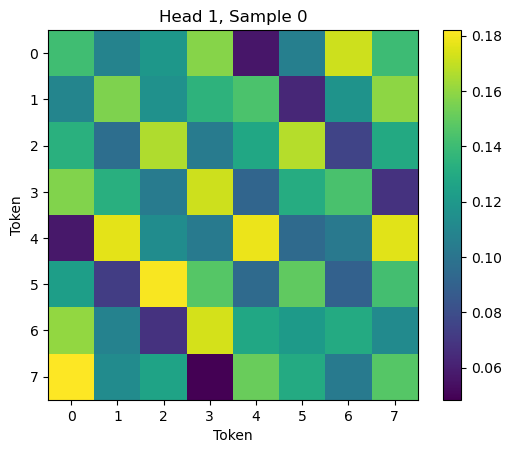

In [596]:
# Visualize one head
plt.imshow(demo[0, 0,:, :])
plt.title("Head 1, Sample 0")
plt.xlabel("Token")
plt.ylabel("Token")
plt.colorbar()

Lets define a function, so that it will be easier in the future to check attention heads

In [632]:
def plot_attention(attention_map: torch.tensor, idx: int, idx_sequence=None):
    """Plot attention maps for specific idx
    
    PARAMS
    ------
        attention_map: torch.tensor
            scaled dot products outputted before V
            
        idx: int
            sample within the batch to plot

        idx_sequence: str
            If supplied, will fill in the x and y ticks
            with the appropriate characters
    """
    # Extract the sample within batch
    sample = attention_map[idx].detach().cpu()
    
    # check if msa or not
    if len(attention_map.shape) == 5:
        sample = torch.sum(sample, axis=1)

    # Extract the head number
    H = sample.size(0)

    # create the number of subplots
    N = H//2

    # create plot
    fig, ax = plt.subplots(N, N, figsize=(6,6), layout="constrained")

    # iter through subplot axes
    rows = torch.arange(N).repeat_interleave(N)
    cols = torch.arange(N).repeat(N)

    if idx_sequence != None:
        sequence_list = list(idx_sequence)

    # now loop through and plot each Head
    for head in range(H):
        # Set individual plto parameters
        heatmap = ax[rows[head], cols[head]].imshow(sample[head, :, :], cmap="viridis")
        ax[rows[head], cols[head]].set_title(f"Head-{head+1}", fontweight="bold")
        ax[rows[head], cols[head]].set_xlabel("Token ($L$)")
        ax[rows[head], cols[head]].set_ylabel("Token ($L$)")
        if idx_sequence != None:
            ax[rows[head], cols[head]].set_xticks(np.arange(sample.size(-1)), labels=sequence_list)
            ax[rows[head], cols[head]].set_yticks(np.arange(sample.size(-1)), labels=sequence_list)
        
        

    # Set global colorbar and title
    fig.colorbar(heatmap, ax=ax, shrink=0.6)
    fig.suptitle(f"Sample-{idx} Attention Heads", fontweight="bold")


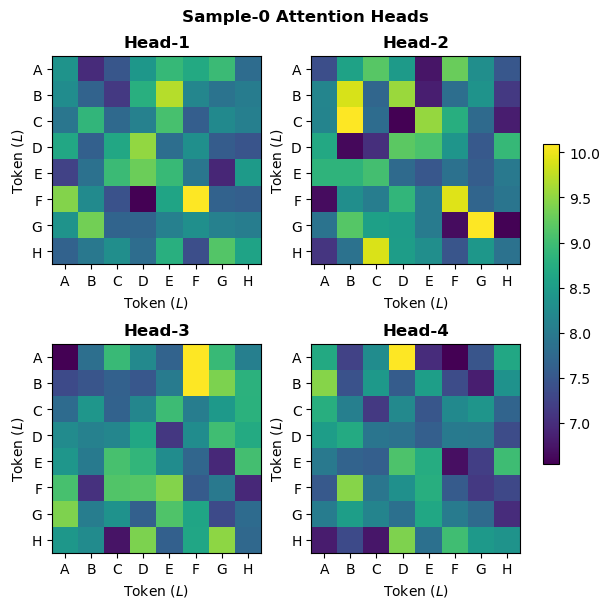

In [636]:
plot_attention(attention_msa, 0, "ABCDEFGH")